In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr')

# Add the root directory of this repository
sys.path.append('../..')

from utils import gen_covariance, gen_beta2, gen_data, get_cov_list
from utils import selection_accuracy
from sklearn.linear_model import LassoLars, lasso_path, LinearRegression

from pyuoi.linear_model import UoI_Lasso

In [3]:
from LLA.lla import LLA
from LLA.lla import dSCAD, dMCP
from LLA.lla import FISTA

In [13]:
import pycasso

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
# %load ../../loaders/datgen.py
n_features = 50
n_samples = 150

sigma = gen_covariance(n_features, 0, n_features, 1, 0)
beta = gen_beta2(n_features, n_features, sparsity = 0.2, betawidth = np.inf)
X, X_test, y, y_test, ss = gen_data(n_samples, n_features, kappa = 100, 
									covariance = sigma, beta = beta)
X = StandardScaler().fit_transform(X)
y -= np.mean(y)

In [8]:
def SCAD_loss(X, y, beta, alpha, gamma):
    MSE = 1/(2 * n_samples) * np.linalg.norm(y - X @ beta)**2
    penalty = np.sum([alpha * np.abs(xi) if np.abs(xi) <= alpha
                      else (2 * gamma * alpha * np.abs(xi) - xi**2 - alpha**2)/(2 * (gamma - 1)) 
                      if np.abs(xi) > alpha and np.abs(xi) < alpha * gamma
                      else alpha**2 * (gamma + 1)/2 for xi in beta])
    
    return MSE + penalty
    

In [9]:
def MCP_loss(X, y, beta, alpha, gamma): 
    
    MSE = 1/(2 * n_samples) * np.linalg.norm(y - X @ beta)**2
    penalty = np.sum([alpha * np.abs(xi) - xi**2/(2 * gamma) if np.abs(xi) <= gamma * alpha
                      else 1/2 * gamma * alpha**2 for xi in beta])
    return MSE + penalty

In [10]:
# A few questions: 
# 1) Verify superiority of Pycasso to LLA using (1) 0 initialization across a few different designs
#                                               (2) Lasso initialization
#                                               (3) SCAD/MCP initialization

In [11]:
# Next up: Debug empirical bayes and the use of aBIC across UoI with the stability selection knob turned down

In [25]:
# Choose a block diagonal, exponential, uncorrelated design matrix, as well as equal and uniformly distributed
# coefficients. Then, do 5 repetitions. Record the selection accuracy, SCAD/MCP loss for all
n_features = 200
n_samples = 800

cov_params = [{'correlation' : 0.25, 'block_size' : 25, 'L' : 1, 't' : 0},
              {'correlation' : 0, 'block_size' : 200, 'L' : 1, 't' : 0},
              {'correlation' : 0.25, 'block_size' : 200, 'L' : 10, 't' : 1}]

sparsity = 0.25
betawidth = [0.1, np.inf]
kappa = [1, 2, 5]
reps = 5

# 3 different initializations
LLA_SCAD_loss = np.zeros((len(cov_params), len(betawidth), len(kappa), reps, 2))
LLA_MCP_loss = np.zeros((len(cov_params), len(betawidth), len(kappa), reps, 2))
pyc_SCAD_loss = np.zeros((len(cov_params), len(betawidth), len(kappa), reps))
pyc_MCP_loss = np.zeros((len(cov_params), len(betawidth), len(kappa), reps))

LLA_SCAD_sa = np.zeros((len(cov_params), len(betawidth), len(kappa), reps, 2))
LLA_MCP_sa = np.zeros((len(cov_params), len(betawidth), len(kappa), reps, 2))
pyc_SCAD_sa = np.zeros((len(cov_params), len(betawidth), len(kappa), reps))
pyc_MCP_sa = np.zeros((len(cov_params), len(betawidth), len(kappa), reps))

for i1, cov_param in enumerate(cov_params):
    for i2, bw in enumerate(betawidth): 
        for i3, k in enumerate(kappa):
            for rep in range(reps): 
                
                # Generate data
                sigma = gen_covariance(n_features, **cov_param)
                beta = gen_beta2(n_features, cov_param['block_size'], sparsity = sparsity,
                                 betawidth = bw)
                X, X_test, y, y_test, ss = gen_data(n_samples, n_features, kappa = k, 
                                                    covariance = sigma, beta = beta)
                X = StandardScaler().fit_transform(X)
                y -= np.mean(y)
                
                ## SCAD ##
                solver = pycasso.Solver(X, y, family='gaussian', useintercept=False, gamma=3,
                                        penalty = 'scad', lambdas = (1, 0.5, 0.25))
                solver.train()
                pyc_coefs = solver.result['beta'][0, :]

                pyc_SCAD_loss[i1, i2, i3, rep] = SCAD_loss(X, y.ravel(), pyc_coefs.ravel(), 1, 3)
                pyc_SCAD_sa[i1, i2, i3, rep] = selection_accuracy(beta.ravel(), pyc_coefs.ravel())

                # Zero initialization
                lla_coefs = LLA(np.zeros(n_features), X, y.ravel(), dSCAD, (3, 1))[0]
                
                LLA_SCAD_loss[i1, i2, i3, rep, 0] = SCAD_loss(X, y.ravel(), lla_coefs.ravel(), 1, 3)
                LLA_SCAD_sa[i1, i2, i3, rep, 0] = selection_accuracy(beta.ravel(), lla_coefs.ravel())
                
                # SCAD initialization
                lla_coefs = LLA(pyc_coefs.ravel(), X, y.ravel(), dSCAD, (3, 1))[0]
                LLA_SCAD_loss[i1, i2, i3, rep, 1] = SCAD_loss(X, y.ravel(), lla_coefs.ravel(), 1, 3)
                LLA_SCAD_sa[i1, i2, i3, rep, 1] = selection_accuracy(beta.ravel(), lla_coefs.ravel())
                
                ## MCP ## 
                solver = pycasso.Solver(X, y, family='gaussian', useintercept=False, gamma=3,
                                        penalty = 'mcp', lambdas = (1, 0.5, 0.25))
                solver.train()
                pyc_coefs = solver.result['beta'][0, :]
                
                pyc_MCP_loss[i1, i2, i3, rep] = MCP_loss(X, y.ravel(), pyc_coefs.ravel(), 1, 3)
                pyc_MCP_sa[i1, i2, i3, rep] = selection_accuracy(beta.ravel(), pyc_coefs.ravel())

                
                # Zero initialization
                lla_coefs = LLA(np.zeros(n_features), X, y.ravel(), dMCP, (3, 1))[0]
                
                LLA_MCP_loss[i1, i2, i3, rep, 0] = MCP_loss(X, y.ravel(), lla_coefs.ravel(), 1, 3)
                LLA_MCP_sa[i1, i2, i3, rep, 0] = selection_accuracy(beta.ravel(), lla_coefs.ravel())
                
                # SCAD initialization
                lla_coefs = LLA(pyc_coefs.ravel(), X, y.ravel(), dMCP, (3, 1))[0]
                LLA_MCP_loss[i1, i2, i3, rep, 1] = MCP_loss(X, y.ravel(), lla_coefs.ravel(), 1, 3)
                LLA_MCP_sa[i1, i2, i3, rep, 1] = selection_accuracy(beta.ravel(), lla_coefs.ravel())
                
                

In [27]:
np.argmax(LLA_SCAD_loss[..., 0].ravel() - pyc_SCAD_loss.ravel())

68

(array([ 1.,  2.,  1.,  0.,  1.,  5.,  0.,  8., 10., 62.]),
 array([-121.59738453, -108.7592492 ,  -95.92111388,  -83.08297856,
         -70.24484324,  -57.40670791,  -44.56857259,  -31.73043727,
         -18.89230195,   -6.05416662,    6.7839687 ]),
 <a list of 10 Patch objects>)

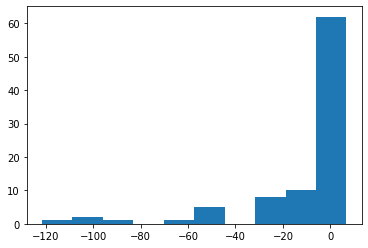

In [31]:
plt.hist(LLA_SCAD_loss[..., 0].ravel() - pyc_SCAD_loss.ravel())

In [19]:
# Achieved loss, 0 initialization
np.where(LLA_MCP_loss[..., 0] < pyc_MCP_loss)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1]),
 array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2,
        2]),
 array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,

In [17]:
LLA_SCAD_loss[..., 0] < pyc_SCAD_loss

array([[[[ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True]],

        [[ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True]]],


       [[[ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True]],

        [[ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True]]],


       [[[ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True]],

        [[ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True]]]])

In [29]:
np.count_nonzero(1 * LLA_SCAD_sa[..., 0] > pyc_SCAD_sa)/pyc_SCAD_sa.size

0.43333333333333335

In [ ]:
# results not dramatic enough to warrant switching away.

In [ ]:
# Testing matrix multiplication

In [33]:
x = np.arange(10000)
y = np.arange(10000)

In [41]:
nlogn = lambda x: x * np.log(x) if x > 0 else 0

In [46]:
nlogn2 = lambda x: np.ma.masked_equal(np.multiply(x, np.log(x)), -np.inf)

In [47]:
%timeit nlogn2(x)

/home/akumar/anaconda3/envs/nse/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/akumar/anaconda3/envs/nse/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


207 µs ± 2.43 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [51]:
thres_log = lambda x : np.array([np.log(xx) if xx > 1 else 0 for xx in x])

In [54]:
thres_log2 = lambda x : np.log(np.maximum(x, 1))

In [52]:
%timeit thres_log(x)

16.5 ms ± 523 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
%timeit thres_log2(x)

148 µs ± 137 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


array([   0,    1,    2, ..., 9997, 9998, 9999])